# Participants Quality Control

**Author**: Haroon Popal

This notebook will create a list of participant and their run data for the social reward task that meets quality control thresholds. Participants may be exluced for excessive motion and/or poor MRI run quality, or if there were issues with their task run data.

In [1]:
import os
import pandas as pd

In [2]:
proj_dir = '/Users/hpopal/Google Drive/My Drive/dscn_lab/projects/scon_social_reward/'

os.chdir(proj_dir)

# Imaging QC

In [3]:
mriqc_raw = pd.read_csv(proj_dir+'misc/SCN fMRI Master Log - QC.csv', index_col=0)
mriqc_raw.head()

,Anatomical,192x512x512,Unnamed: 3,Unnamed: 4,Unnamed: 5,HBN movie - Run 1,Unnamed: 7,NS - Run 1,Unnamed: 9,NS - Run 2,...,Unnamed: 17,SR - Run 3,Unnamed: 19,SR - Run 4,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
2,,,,,,,,,,,,,,,,,,,,,
SID,T1w,Dimension #s,Norm1,Norm2,Norm3,Alignment,Time: # of Volumes,Alignment,Time: # of Volumes,Alignment,...,Time: # of Volumes,Alignment,Time: # of Volumes,Alignment,Time: # of Volumes,Error Messages,Checked Reprocessed Data?,Overall Notes,"frontal drop-off rating (1=least, 5=most)",wrap-around artifact
SCN_101,good,192x512x512,good,good,good,good,170,good,518.75,good,...,300,good,300,good,300,Node Name: fmriprep_wf.single_subject_SCN101_w...,TRUE,"smudging in NS 2 and SR 2, general pixellation...",5,yes
SCN_102,good,192x512x512,good,good,good,good,170,good,518.75,good,...,300,good,300,good,300,No errors to report!,TRUE,pixellation in all moving runs,1,no
SCN_103,good,192x512x512,good,good,good,good,170,good,518.75,good,...,300,good,300,good,300,No errors to report!,TRUE,NaN,4,yes
SCN_104,good,192x512x512,good,good,good,good,170,good,518.75,good,...,300,good,300,good,300,No errors to report!,TRUE,"most have some smudges, but small enough (NS 1...",2,yes


In [4]:
# Drop irrelevant rows
mriqc = mriqc_raw.drop([x for x in mriqc_raw.index if not str(x).startswith('SCN')])

# Remove irrelvant columns
irr_col_names = [x for x in mriqc.columns if not x.startswith('SR - ')]
mriqc = mriqc.drop(columns=irr_col_names)

# Add fmriprep sub- prefix
mriqc.index = 'sub-'+ mriqc.index

# Remove underscore for participant ID
mriqc.index = [sub.replace('_', '') for sub in mriqc.index]

# Name index column
mriqc.index.name = 'participant_id'

mriqc.head()

,SR - Run 1,SR - Run 2,SR - Run 3,SR - Run 4
participant_id,,,,
sub-SCN101,good,good,good,good
sub-SCN102,good,good,good,good
sub-SCN103,good,good,good,good
sub-SCN104,good,good,good,good
sub-SCN105,good,good,good,good


In [5]:
# Clean up extra spaces at the end of column values
for col in mriqc.columns:
    mriqc[col] = mriqc[col].str.strip()

In [6]:
mriqc_melt = pd.melt(mriqc.reset_index(), id_vars='participant_id', var_name='run')
mriqc_melt

,participant_id,run,value
0,sub-SCN101,SR - Run 1,good
1,sub-SCN102,SR - Run 1,good
2,sub-SCN103,SR - Run 1,good
3,sub-SCN104,SR - Run 1,good
4,sub-SCN105,SR - Run 1,good
...,...,...,...
451,sub-SCN251,SR - Run 4,good
452,sub-SCN253,SR - Run 4,good
453,sub-SCN254,SR - Run 4,bad
454,sub-SCN255,SR - Run 4,NaN


<Axes: xlabel='run,value'>

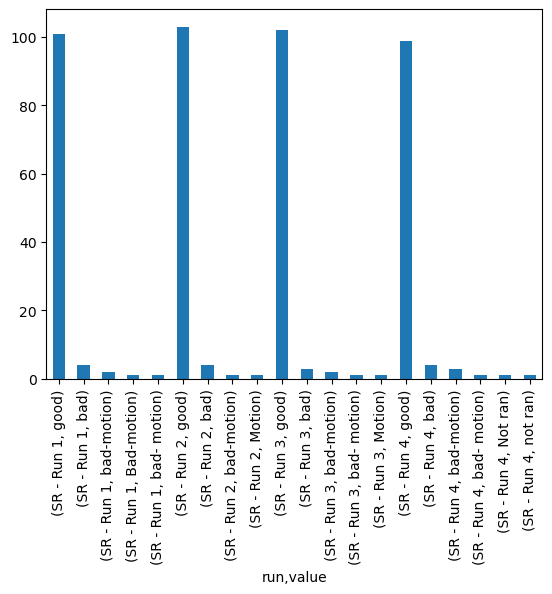

In [7]:
mriqc_melt.groupby('run')['value'].value_counts().plot.bar()

In [8]:
mriqc_melt_good = mriqc_melt[mriqc_melt['value'] == 'good']

#mriqc_melt_good[['participant_id','run']].to_csv(proj_dir+'derivatives/participants_good.csv', index=False)

<Axes: xlabel='run,value'>

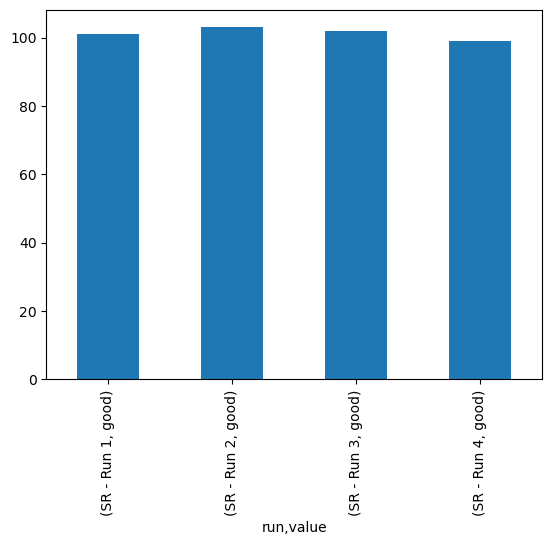

In [9]:
mriqc_melt_good.groupby('run')['value'].value_counts().plot.bar()

# Behavioral QC
The task programming had an error which would show the participant incorrect options for their own preferences (e.g. would show "like animals", when the participant said they didn't like animals). We will remove participants for which this occurred a lot (more than 5 trial).

In [10]:
task_audit = pd.read_csv(os.path.join(proj_dir, 'derivatives', 'task_socialreward', 'data', 
                                      'answer_errors_sum.csv'), index_col=0)
task_audit.head()

,num_errors
SCN_101,0
SCN_102,0
SCN_103,0
SCN_104,0
SCN_105,0


Create a list of subjects that had no task errors

In [11]:
# Filter subjects for no errors
task_audit_pass_subjs = task_audit.index[task_audit['num_errors'] == 0]

# Change subject labels to match MRI data
task_audit_pass_subjs = ['sub-'+x.replace('_','') for x in task_audit_pass_subjs]

Filter the MRI QC passed subjects with the behavioral QC passed subjects

In [12]:
mriqc_melt_good_bhav = mriqc_melt_good[mriqc_melt_good['participant_id'].isin(task_audit_pass_subjs)]

<Axes: xlabel='run,value'>

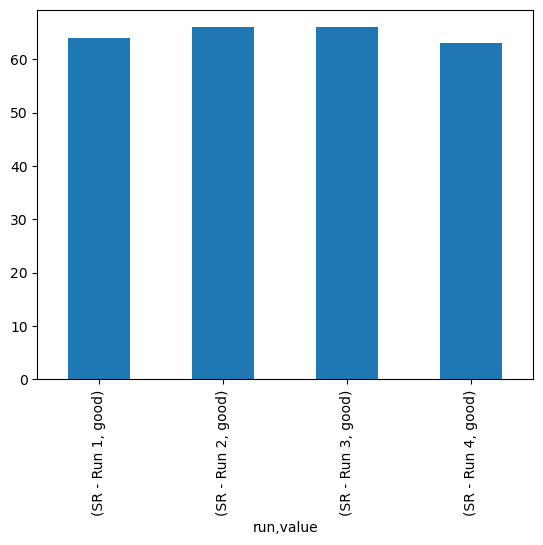

In [13]:
mriqc_melt_good_bhav.groupby('run')['value'].value_counts().plot.bar()

In [14]:
mriqc_melt_good_bhav[['participant_id','run']].to_csv(proj_dir+'derivatives/participants_good.csv', 
                                                      index=False)